In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers.convolutional import Conv1D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',infer_datetime_format=True,low_memory=True)

In [ ]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [ ]:
df=pd.get_dummies(data=df, columns=['cbwd'])

In [ ]:
df=df.drop(columns=['No','day','month','year','hour'])

In [ ]:
df

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
43820,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
43821,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0
43822,8.0,-22,-4.0,1034.0,246.72,0,0,0,1,0,0


In [ ]:
df=df.fillna(method='bfill')

In [ ]:
df.isna().sum()

pm2.5      0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NE    0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
dtype: int64

In [ ]:
df=df.drop(columns=['TEMP'])

In [ ]:
df

,pm2.5,DEWP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,129.0,-21,1021.0,1.79,0,0,0,1,0,0
1,129.0,-21,1020.0,4.92,0,0,0,1,0,0
2,129.0,-21,1019.0,6.71,0,0,0,1,0,0
3,129.0,-21,1019.0,9.84,0,0,0,1,0,0
4,129.0,-20,1018.0,12.97,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,1034.0,231.97,0,0,0,1,0,0
43820,10.0,-22,1034.0,237.78,0,0,0,1,0,0
43821,10.0,-22,1034.0,242.70,0,0,0,1,0,0
43822,8.0,-22,1034.0,246.72,0,0,0,1,0,0


# Splitting

In [ ]:
def traintest_split(dataset):
    x=35064
    train_data=dataset[:x]
    test_data=dataset[x:]
    return train_data,test_data

In [ ]:
print("Time-series hourly data")
train_data,test_data=traintest_split(df)
print(train_data.shape)
print(test_data.shape)

Time-series hourly data
(35064, 10)
(8760, 10)


# **Scaling**

In [ ]:
def scaling(train,test):
  scaler=MinMaxScaler(feature_range=(0,1))
  a=scaler.fit_transform(train)
  b=scaler.transform(test)
  return a,b

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
a=scaler.fit_transform(train_data)
b=scaler.transform(test_data)

In [ ]:
scaled_train_data,scaled_test_data=scaling(train_data,test_data)

In [ ]:
print(scaled_train_data.shape)
print(scaled_test_data.shape)

(35064, 10)
(8760, 10)


# **Supervised Form**

In [ ]:
def series_to_supervised(dataset,look_back,horizon):
  x=[]
  y=[]
  for i in range(len(dataset)):
    # find the end of this pattern
    end_ix = i + look_back
    # check if we are beyond the dataset
    if end_ix > len(dataset)-horizon:
      break
    # gather input and output parts of the pattern
    data_x, data_y = dataset[i:end_ix,0:], dataset[end_ix:end_ix+horizon,0]
    x.append(data_x)
    y.append(data_y)
  return np.array(x), np.array(y)

In [ ]:
horizon=1
x_train1,y_train1=series_to_supervised(scaled_train_data,12,horizon)
x_test1,y_test1=series_to_supervised(scaled_test_data,12,horizon)

In [ ]:
x_train1= np.reshape(x_train1, (x_train1.shape[0],x_train1.shape[1],10))
x_test1= np.reshape(x_test1, (x_test1.shape[0],x_test1.shape[1],10))


In [ ]:
print("x_train  " + str(x_train1.shape))
print("y_train  " + str(y_train1.shape))
print("x_test  " + str(x_test1.shape))
print("y_test  " + str(y_test1.shape))

x_train  (35052, 12, 10)
y_train  (35052, 1)
x_test  (8748, 12, 10)
y_test  (8748, 1)


# **Loss Graph Function**

In [ ]:
def loss_graph(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,(len(loss_train))+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Proposed Method

In [ ]:
model1 = Sequential()
model1.add(Conv1D(filters=32, kernel_size=4,activation='relu', input_shape=(12, 10)))
model1.add(Conv1D(filters=16, kernel_size=2,activation='relu'))
model1.add(LSTM(16,activation='tanh',return_sequences=True)) 
model1.add(LSTM(8,activation='tanh',return_sequences=True))
model1.add(LSTM(4,activation='tanh'))
model1.add(Dense(1))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss='mse')

In [ ]:
es=EarlyStopping(monitor='val_loss',patience=5,verbose=1)

In [ ]:
history1=model1.fit(x_train1, y_train1, epochs=50,batch_size=32,validation_data=(x_test1,y_test1),callbacks=[es])

Epoch 1/50
1096/1096 [==============================] - 32s 24ms/step - loss: 0.0016 - val_loss: 6.1317e-04
Epoch 2/50
1096/1096 [==============================] - 24s 22ms/step - loss: 6.8945e-04 - val_loss: 6.2406e-04
Epoch 3/50
1096/1096 [==============================] - 24s 22ms/step - loss: 6.2360e-04 - val_loss: 4.8969e-04
Epoch 4/50
1096/1096 [==============================] - 24s 22ms/step - loss: 5.9535e-04 - val_loss: 4.6675e-04
Epoch 5/50
1096/1096 [==============================] - 24s 22ms/step - loss: 5.8925e-04 - val_loss: 5.2749e-04
Epoch 6/50
1096/1096 [==============================] - 23s 21ms/step - loss: 5.8328e-04 - val_loss: 4.7622e-04
Epoch 7/50
1096/1096 [==============================] - 24s 22ms/step - loss: 5.7475e-04 - val_loss: 4.6976e-04
Epoch 8/50
1096/1096 [==============================] - 23s 21ms/step - loss: 5.6280e-04 - val_loss: 4.5425e-04
Epoch 9/50
1096/1096 [==============================] - 23s 21ms/step - loss: 5.6527e-04 - val_loss: 4.5326e

### **Loss Graph**

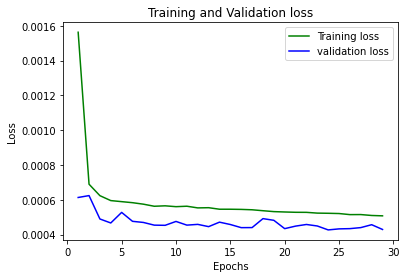

In [ ]:
loss_graph(history1)

# Train

In [ ]:
y_pred_train=model1.predict(x_train1)

In [ ]:
forecast_copies = np.repeat(y_pred_train, x_train1.shape[2], axis=-1)
y_pred_train = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
df_train_predicted=pd.DataFrame(data=y_pred_train, columns=['Predicted_train'])

In [ ]:
actual_copies = np.repeat(y_train1, x_train1.shape[2], axis=-1)
y_actual_train = scaler.inverse_transform(actual_copies)[:,0]

In [ ]:
df_train_actual=pd.DataFrame(data=y_actual_train ,columns=['Actual_train'])

In [ ]:
df1=pd.concat([df_train_actual,df_train_predicted],axis=1)

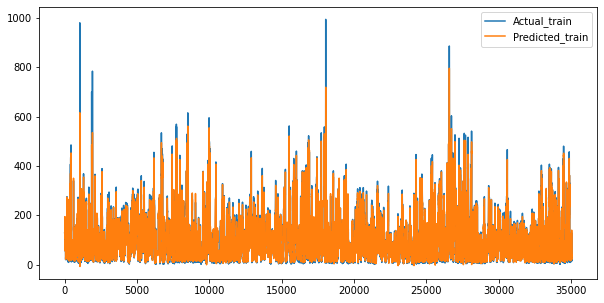

In [ ]:
df1.plot(figsize=(10,5))

In [ ]:
import math
trainScore = math.sqrt(mean_squared_error(df1['Actual_train'],df1['Predicted_train']))
print('Train Score: %.2f RMSE' % (trainScore))
trainScore1 =mean_absolute_error(df1['Actual_train'],df1['Predicted_train'])
print('Train Score: %.2f MSE' % (trainScore1))

Train Score: 22.17 RMSE
Train Score: 12.69 MSE


# Test

In [ ]:
y_pred_test=model1.predict(x_test1)

In [ ]:
forecast_copies = np.repeat(y_pred_test, x_test1.shape[2], axis=-1)
y_pred_test = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
df_test_predicted=pd.DataFrame(data=y_pred_test, columns=['Predicted'])

In [ ]:
actual_copies = np.repeat(y_test1, x_test1.shape[2], axis=-1)
y_actual_test = scaler.inverse_transform(actual_copies)[:,0]

In [ ]:
df_test_actual=pd.DataFrame(data=y_actual_test ,columns=['Actual'])

In [ ]:
df2=pd.concat([df_test_actual,df_test_predicted],axis=1)

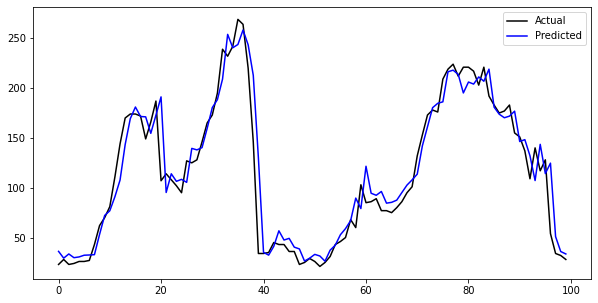

In [ ]:
df2['Actual'][:100].plot(figsize=(10,5),c='black',label='Actual')
df2['Predicted'][:100].plot(figsize=(10,5),c='blue',label='Predicted')
plt.legend()
plt.show()

In [ ]:
import math
testScore = math.sqrt(mean_squared_error(df2['Actual'],df2['Predicted']))
print('Test Score: %.2f RMSE' % (testScore))
testScore1 =mean_squared_error(df2['Actual'],df2['Predicted'])
print('Test Score: %.2f MSE' % (testScore1))

Test Score: 21.06 RMSE
Test Score: 443.58 MSE


In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
import math
testScore2 = mean_absolute_error(df2['Actual'],df2['Predicted'])
print('Test Score: %.2f MAE' % (testScore2))

Test Score: 11.93 MAE
